# Overview
I interested in finding out if the rating on Yelp of a restaurant is affected if the restaurant violated a critical health safety conduct. If there's a correlation, people can use the Yelp app in the future to avoid restaurant that didn't met the health inspection requirement.

# Name - PID
Son Ho - A14719861

# Research question

If a restaurant violate critical health safety requirement, is the Yelp rating of the restaurant going to be lower compared to restaurant that doesn't violate the critical requirement?

# Background and Prior Work
The process of health inspection is described as “One inspection may not be representative of the overall, long-term sanitation of an establishment. On any given day, a restaurant may have greater or fewer violations than observed during an inspection. In addition, some violations noted on an inspection report may have been corrected at the time of the inspection, which are indicated on the report. Follow-up inspections may be conducted for specific critical violations that cannot be corrected at the time of the inspection." (Challenges of Health Department Food Safety Inspections article)

However, due to limited budget, a challenge that the health inspection faced is the fact that there's a lot of restaurant that is only inspected once on quarterly basis, and in some case, once a year. This seems like a bad idea because as stated above, frequent inspection is a way to keep the business uphold their standards (Challenges of Health Department Food Safety Inspections article)

Due to the fact that the health inspection process is not performed regularly, the number of critical violations that are reported will likely stay for a whole year. Since Yelp implemented the ability to check the violations of a restaurant (npr.org article), it is possible to check if the rating of the restaurant is affected based on the yelp data.

References (include links):
- 1) https://www.dininggrades.com/blog/challenges-of-health-department-food-safety-inspections/
- 2) https://www.npr.org/sections/thesalt/2015/03/27/395622262/did-that-restaurant-pass-its-health-inspection-now-yelp-will-tell-you

# Hypothesis

There is a correlation between Yelp rating and critical health safety violation of a restaurant. The rating score is likely lower if the restaurant doesn't met the critical health requirement, and is likely higher otherwise. I also think that the number of critical violations, as well as the number of non-critical violation, will affect the rating score

# Datasets
The data is given by the professor due to the nature of personal project. I used 4 datasets, which are restaunts.csv, yelp.csv, violations.csv and inspections.csv. The restaurants data include information about the data such as name, address and zip code, the yelp data include information about the rating, the violations include the information about whether a restaurant violated a critical health requirement, and the inspection data include information about the number of critical/non-critical violations.

In order to use the dataset, I combines the restaurant data and inspection data first to get the number of violations for each restaurant. After that, I combine that dataset with violations data, to add the indication of whether or not the restaurant violate the critical requirement to the combined dataset. Finally, I combine this dataset to yelp data, to get a dataset that include all the information needed to carry out the analysis

# Setup

In [1]:
# Display plots directly in the notebook instead of in a new window
%matplotlib inline

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

In [2]:
# Configure libraries
# The seaborn library makes plots look nicer
sns.set()
sns.set_context('talk')

# Don't display too many rows/cols of DataFrames
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8

# Round decimals when displaying DataFrames
pd.set_option('precision', 2)

# Importing data

In [3]:
df_restaurant = pd.read_csv('restaurants.csv')
df_reviews = pd.read_csv('yelp.csv')
df_violations = pd.read_csv('violations.csv')
df_inspection = pd.read_csv('inspections.csv')

# Data cleaning
Since I only interested in the number of time that a restaurant is inspected, I dropped every column from inspection data beside the id and the number of inspection, along with the data that show the critical/non-critical inspection that happened. 

After that, I start to drop the column that I think unecessary from the restaurant dataset. Finally, I merge the data to a new dataframe using hsisid.

In [4]:
# Drop unecessary/private information from inspection data
df_inspection = df_inspection.drop(columns=['date', 'address2','city','state','phonenumber','restaurantopendate','days_from_open_date',
                                                'facilitytype','x','y','geocodestatus','type','description','inspectedby','inspector_id',
                                                'previous_inspection_date','days_since_previous_inspection','previous_inspection_by_same_inspector',
                                               'num_critical_previous','num_non_critical_previous','avg_neighbor_num_critical','avg_neighbor_num_non_critical','top_match',
                                                'second_match','critical','num_critical_mean_previous','num_non_critical_mean_previous'])

# Drop uncessary/private information from restaurant data
df_restaurant = df_restaurant.drop(columns=['state','city','phonenumber','restaurantopendate','facilitytype','x','y','geocodestatus',
                                            'address2','postalcode'])

# Merge the data
num_inspect_res = pd.merge(left=df_restaurant, right=df_inspection, on=['hsisid'], how='inner')

In [5]:
num_inspect_res

,X.objectid,hsisid,name_x,address1_x,...,inspection_num,score,num_critical,num_non_critical
0,1001,4092017230,SPRING CAFE 2,2900-104 SPRING FOREST RD,...,1,88.0,9,7
1,1003,4092014444,Taco Bell #22798,2207 S MAIN ST,...,1,99.0,1,6
2,1003,4092014444,Taco Bell #22798,2207 S MAIN ST,...,2,99.5,2,4
...,...,...,...,...,...,...,...,...,...
18463,2997,4092016663,BOJANGLES #5,3301 S WILMINGTON ST,...,6,97.0,3,3
18464,2999,4092017227,QUICKLY,4141 DAVIS DR,...,1,90.0,7,14
18465,3000,4092017274,HARRIS TEETER #43 STARBUCKS,3638 ROGERS RD,...,1,98.5,3,1


After merging, I found that there's a lot of rows that is repeated, so I drop all the row that have the same hsisid, and only keep the first instance of it 

In [6]:
num_inspect_res= num_inspect_res.drop_duplicates(subset='hsisid', keep="first")

Next I drop the data that I deems unecessary in the violations data, such as description, comments, etc..., and data that violate privacy practice such as name of the inspector. Then I merge the data from the dataframe that I obtained above using X.objectid to receive the new dataframe that include a list of restaurants with the number of time that restaurant is inspected.

In [7]:
# Drop the unecessary/private information
df_violations = df_violations.drop(columns=['violationtype', 'cdcdataitem', 'cdcriskfactor', 'count','observationtype','inspectdate',
                                   'inspectedby','statecode','questionno','shortdesc','comments','pointvalue','category','violationcode'])
# Merge the data
res_data = pd.merge(left=num_inspect_res, right=df_violations, on=['X.objectid'], how='inner')

In [8]:
res_data

,X.objectid,hsisid_x,name_x,address1_x,...,num_non_critical,hsisid_y,critical,severity
0,1001,4092017230,SPRING CAFE 2,2900-104 SPRING FOREST RD,...,7,4092016194,Yes,Priority Foundation
1,1003,4092014444,Taco Bell #22798,2207 S MAIN ST,...,6,4092015221,Yes,Priority Foundation
2,1004,4092015333,THE REMEDY DINER,137 E HARGETT ST,...,2,4092014885,Yes,Priority Foundation
...,...,...,...,...,...,...,...,...,...
3042,2997,4092016663,BOJANGLES #5,3301 S WILMINGTON ST,...,2,4092015457,Yes,Priority
3043,2999,4092017227,QUICKLY,4141 DAVIS DR,...,14,4092014946,Yes,Priority Foundation
3044,3000,4092017274,HARRIS TEETER #43 STARBUCKS,3638 ROGERS RD,...,1,4092017004,Yes,Priority Foundation


There are some column that is repeated after merging, so I dropped those column and rename some column to be more clear

In [9]:
# Drop unessary information and rename column
res_data = res_data.drop(columns=['hsisid_x','hsisid_y','severity', 'name_y', 'address1_y','postalcode'])
res_data.rename(columns={"name_x": "name", "address1_x": "address", "X.objectid":"ID", "zip":"zip_code"},inplace=True)

res_data.head()

,ID,name,address,zip_code,...,score,num_critical,num_non_critical,critical
0,1001,SPRING CAFE 2,2900-104 SPRING FOREST RD,27616,...,88.0,9,7,Yes
1,1003,Taco Bell #22798,2207 S MAIN ST,27587,...,99.0,1,6,Yes
2,1004,THE REMEDY DINER,137 E HARGETT ST,27601,...,98.5,1,2,Yes
3,1005,ZEBULON HOUSE (KITCHEN),551 PONY RD,27597,...,96.5,3,8,Yes
4,1006,CHARLES BUGG CAFETERIA,825 COOPER ST,27610,...,98.5,2,2,Yes


After checking the reviews data from yelp, I noticed that some restaurant doesn't have an address. Therefore, I dropped the row that doesn't have the address available, since I need the address to merge the data, with the merged dataset above. After dropping the row with missing address, I dropped the column that contains information that is not helpful for my analysis. Finally, I think that review count is only matter if the number of review for a restaurant is more than 10, thus, I remove the row where the number of reviews is less than 10.

In [10]:
df_reviews = df_reviews.dropna(subset=['address1'])
df_reviews = df_reviews.drop(columns=['id','latitude','longitude','price','phone','hotdogs','sandwiches','pizza','tradamerican',
                                    'burgers','mexican','grocery','breakfast_brunch','coffee','chinese','italian','newamerican',
                                    'chicken_wings','delis','bars','salad','seafood','bbq','bakeries','sushi'])
df_reviews = df_reviews[df_reviews["review_count"] >= 10]

In [11]:
df_reviews

,name,is_closed,rating,review_count,address1,zip_code
0,42nd street oyster bar - rdu airport,False,2.5,23,2400 John Brantley Blvd,27560
1,aldi foods,False,4.0,17,2303 NW Maynard Rd,27519
3,olive garden italian restaurant,False,3.0,16,3401 Raleigh Rd Pkwy W,27893
...,...,...,...,...,...,...
3683,carter-finley stadium,False,3.5,23,4600 Trinity Rd,27607
3684,raleigh little theatre,False,3.5,24,301 Pogue St,27607
3685,"sky zone trampoline park, durham",False,4.0,12,1720 Guess Rd,27701


Since the address in the merged dataset is all upper-cased, compared to a normally formatted address in the review dataset, I first transform the address of of both dataset to all lower-cased to a new column in both dataset, then I merge the datasets using the new column and the zip code. Finally, I remove the repeated rows and columns to obtained the final dataset that I will use for analyzing.

In [12]:
# Lower 
df_reviews['address_lower'] = df_reviews['address1'].str.lower()
res_data['address_lower'] = res_data['address'].str.lower()
df_final = pd.merge(left=df_reviews, right=res_data, on=['address_lower'], how='inner')
df_final = df_final.drop_duplicates(subset='address', keep="first")
df_final = df_final.drop(columns=['name_x','is_closed', 'address1', 'address_lower','zip_code_y',
                                'name_y','ID', 'score', 'address'])
df_final

,rating,review_count,zip_code_x,inspection_num,num_critical,num_non_critical,critical
0,3.5,25,27610,1,6,7,Yes
2,4.0,20,27545,1,3,11,Yes
3,3.5,23,27606,1,4,6,Yes
...,...,...,...,...,...,...,...
218,4.0,10,27511,1,2,3,Yes
219,2.5,159,27518,1,1,4,Yes
220,4.0,50,27601,1,9,19,Yes


# Visualization

First of all, I used bar plot to check to see if the rating is affected if the restaurant violated critical safety measure

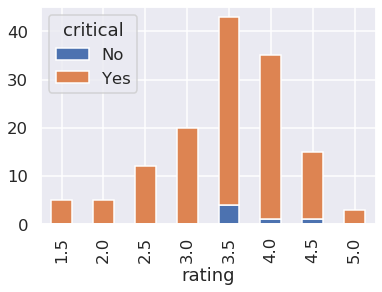

In [13]:
df_final.groupby(['rating','critical']).size().unstack().plot(kind='bar',stacked=True)
plt.show()

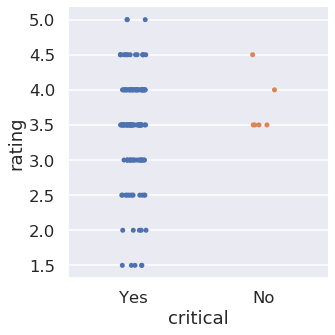

In [14]:
sns.catplot(x="critical", y="rating", data=df_final);

I also want to check if the number of critical and non critical violation affect the rating, so I plot the data using a point graph for each critical and non-critical amount of violation

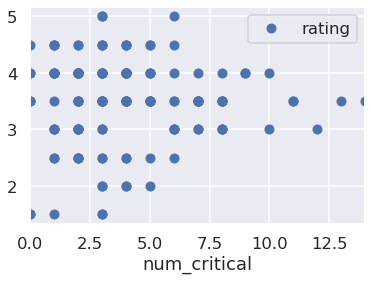

In [15]:
df_final.plot(x='num_critical', y='rating', style='o')

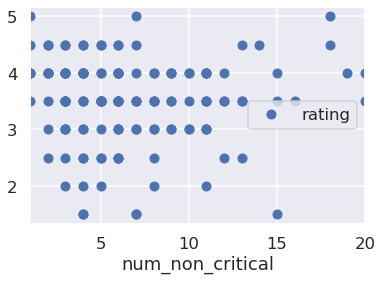

In [16]:
df_final.plot(x='num_non_critical', y='rating', style='o')

# Analysis

Based on the above graphs, it seems that even when the restaurant have violated critical violation, the rating doesn't seems to get affected by it. Moreover, the number of violations, whether critical of non-critical, doens't seems to affect the rating of the restaurant. In order to confirm this claim, I calculate the mean and check to see if they are similar, along with checking the correlation of the data.

In [17]:
rating_critical=df_final[df_final['critical']== 'Yes']['rating'].values
rating_non_critical=df_final[df_final['critical']== 'No']['rating'].values

avg_critical = rating_critical.mean()
avg_non_critical = rating_non_critical.mean()
print('Average rating score of restaurant that have violated critical safety issue is: \t{:2.2f}'.format(avg_critical))
print("Average rating score of restaurant that don't violate critical safety issue is: \t{:2.2f}".format(avg_non_critical))

Average rating score of restaurant that have violated critical safety issue is: 	3.47
Average rating score of restaurant that don't violate critical safety issue is: 	3.75


In [18]:
def binary_change(string):
    if string == "Yes":
        return 1
    else:
        return 0

df_final['critical'] = df_final['critical'].apply(binary_change)
corr = df_final.corr()
corr

,rating,review_count,zip_code_x,inspection_num,num_critical,num_non_critical,critical
rating,1.00e+00,0.29,0.13,NaN,2.16e-02,2.22e-03,-1.21e-01
review_count,2.94e-01,1.00,0.07,NaN,-3.09e-02,-8.14e-02,1.25e-02
zip_code_x,1.33e-01,0.07,1.00,NaN,9.98e-02,1.68e-01,3.29e-02
inspection_num,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_critical,2.16e-02,-0.03,0.10,NaN,1.00e+00,4.90e-01,-7.29e-03
num_non_critical,2.22e-03,-0.08,0.17,NaN,4.90e-01,1.00e+00,-4.60e-02
critical,-1.21e-01,0.01,0.03,NaN,-7.29e-03,-4.60e-02,1.00e+00


Whether or not the restaurant violated critical health requirement, the average rating score is close, where it supposed to be greatly difference based on the hypothesis, since if the critical violation affect the rating, the average rating should be lower when there's a critical violation, and higher otherwise. This is not the case.

Moreover, the correlation table prove the there's no correlation between critical violation and rating score, and the amount of critical/non-critical violation is also have no correlation with the rating. Therefore, I failed to prove the hypothesis, thus, prove that the critical violation doesn't have any effect on the Yelp reviews to the restaurant

# Privacy and ethics

The analysis is performed on restaurants with address, and geo coordination given, along with the name of the inspector for each restaurant. In order to maintain privacy, I have performed steps such as stripping the data of private information such as name, address, x/y coordination of the restaurant, geolocation information.

I think my question/hypothesis is ethical since I simply try to analyze the effect of health inspection on restaurant review, and what I did is trying to find if this problem affect the customers experience at the restaurant in general. The data that I gathered is already available to the publics (Yelp/Google reviews), and after cleaning the data, it's impossible to track which restaurant violated the critical requirement, and it won't affect their business.

The data is picked up randomly from all the local restaurants, so there's no biased contains in the data. However, since the data only picked from local restaurant, it's not representative of all the restaurant that is available on Yelp.

# Conclusion and Dicussion